---

# Utilities Pipeline

### 00 Loading Data

In [1]:
%load_ext autoreload
%autoreload 2

from sklearn.pipeline import make_pipeline, make_union, FunctionTransformer
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer

import pandas as pd
pd.options.display.float_format = '{:.2f}'.format


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from etl.utilities import Utilities

## Would load cleaned data using '''load.py''' once data cleaning is done
data = Utilities().get_training_data()

# Drop unecessary ID and plot information
data.drop(columns=['building_id', 'plot_id'], inplace=True)

# create X and y
X = data.drop(columns='electricity_demmand')
y = data['electricity_demmand']

# create train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_features = list(X_train.columns)
data.dtypes
X_train.head(3)




,building_typology,building_gfa,primary_gfa,secondary_typology,secondary_gfa,year_built,occupancy,num_buildings
15458,residential,92950,92950.00,residential,92950.00,1927,100,1
3069,residential,58321,58321.00,residential,58321.00,1930,100,1
4840,residential,199635,157770.00,office,33492.00,1982,100,1


In [3]:
# use this cell to analyse train data

### 01 Preprocessor 🧮 (1. feature engineering + 2. enocding/scaling)

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion

# Define feature engineering functions
def calculate_occupied_area(data):
    data["occupied_area"] = data['building_gfa'] * (data['occupancy'] * 0.01)
    return data

def calculate_new_build(data):
    data["new_build"] = 0  # Initialize to 0
    
    # Update to 1 for rows where the condition is met
    data.loc[data['year_built'] >= 2000, 'new_build'] = 1
    
    return data

# convert functions to transformers
occupied_area = FunctionTransformer(calculate_occupied_area, validate=False)
new_build = FunctionTransformer(calculate_new_build, validate=False)

# create feature engineering tranformer
feature_engineering = ColumnTransformer(
    [
        ("occupied_area", occupied_area, ['building_gfa','occupancy' ]),
        ("new_build", new_build,['year_built'] )
    ],
    remainder="passthrough"
).set_output(transform = "pandas")

pd.DataFrame(feature_engineering.fit_transform(X_train))

c:\Users\hramzan\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


,occupied_area__building_gfa,occupied_area__occupancy,occupied_area__occupied_area,new_build__year_built,new_build__new_build,remainder__building_typology,remainder__primary_gfa,remainder__secondary_typology,remainder__secondary_gfa,remainder__num_buildings
15458,92950,100,92950.00,1927,0,residential,92950.00,residential,92950.00,1
3069,58321,100,58321.00,1930,0,residential,58321.00,residential,58321.00,1
4840,199635,100,199635.00,1982,0,residential,157770.00,office,33492.00,1
32964,40635,100,40635.00,1940,0,residential,40635.00,residential,40635.00,1
17653,102000,100,102000.00,1939,0,residential,99000.00,office,3000.00,1
...,...,...,...,...,...,...,...,...,...,...
17650,269262,100,269262.00,1912,0,residential,240413.00,retail,28849.00,1
18741,65941,100,65941.00,2009,1,education,65941.00,education,65941.00,1
8050,93360,100,93360.00,1929,0,residential,93360.00,residential,93360.00,1
1404,258315,95,245399.25,1925,0,office,231315.00,retail,27000.00,1


In [5]:
# OPTION 01 Encoding and Scaling
num_preproc = Pipeline([
    ("num_imputer", SimpleImputer(strategy = "constant", fill_value=0.)),
    ("scaler", RobustScaler())
])

cat_preproc = Pipeline([
    ("cat_imputer", SimpleImputer(strategy = "constant", fill_value="Missing")),
    ("ohe", OneHotEncoder(handle_unknown = "ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num_transformer", num_preproc, make_column_selector(dtype_include = ["float64", "int64"])),
    ("cat_transformer", cat_preproc, make_column_selector(dtype_include = ["object"]))
])
preprocessor
pd.DataFrame(preprocessor.fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,0.32,0.34,0.68,-0.15,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.14,-0.13,0.11,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1.73,1.22,-0.30,1.26,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.38,-0.37,-0.18,0.18,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.44,0.42,-0.80,0.15,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15560,2.66,2.34,-0.37,-0.54,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
15561,-0.04,-0.03,0.24,1.95,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
15562,0.32,0.35,0.69,-0.10,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
15563,2.51,2.21,-0.41,-0.21,-5.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [6]:
preprocessor = Pipeline([
    ("feature_engineering", feature_engineering),
    ("preprocessing", preprocessor)]).set_output(transform = "pandas")

preprocessor

c:\Users\hramzan\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


Pipeline(steps=[('feature_engineering',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('occupied_area',
                                                  FunctionTransformer(func=<function calculate_occupied_area at 0x0000021D101CE0C0>),
                                                  ['building_gfa',
                                                   'occupancy']),
                                                 ('new_build',
                                                  FunctionTransformer(func=<function calculate_new_build at 0x0000021D0DB13BA0>),
                                                  ['year_built'])])),
                ('preprocessing',
                 Col...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021D75511110>),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021D75511350>)]))])

In [7]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_train_transformed

print("Original training set")
display(X_train.head(3))

print("Preprocessed training set")
# display(pd.DataFrame(X_train_transformed, columns=['occupied_area'] + preprocessor.get_feature_names_out()).head(5))
display(pd.DataFrame(X_train_transformed))

Original training set


,building_typology,building_gfa,primary_gfa,secondary_typology,secondary_gfa,year_built,occupancy,num_buildings
15458,residential,92950,92950.00,residential,92950.00,1927,100,1
3069,residential,58321,58321.00,residential,58321.00,1930,100,1
4840,residential,199635,157770.00,office,33492.00,1982,100,1


Preprocessed training set


,num_transformer__occupied_area__building_gfa,num_transformer__occupied_area__occupancy,num_transformer__occupied_area__occupied_area,num_transformer__new_build__year_built,num_transformer__new_build__new_build,num_transformer__remainder__primary_gfa,num_transformer__remainder__secondary_gfa,num_transformer__remainder__num_buildings,cat_transformer__remainder__building_typology_community,cat_transformer__remainder__building_typology_courthouse,...,cat_transformer__remainder__secondary_typology_restaurant,cat_transformer__remainder__secondary_typology_retail,cat_transformer__remainder__secondary_typology_self-storage_facility,cat_transformer__remainder__secondary_typology_senior_care_community,cat_transformer__remainder__secondary_typology_social/meeting_hall,cat_transformer__remainder__secondary_typology_supermarket/grocery_store,cat_transformer__remainder__secondary_typology_swimming_pool,cat_transformer__remainder__secondary_typology_urgent_care/clinic/other_outpatient,cat_transformer__remainder__secondary_typology_vocational_school,cat_transformer__remainder__secondary_typology_worship_facility
15458,0.32,0.00,0.33,-0.15,0.00,0.34,0.68,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3069,-0.14,0.00,-0.14,-0.08,0.00,-0.13,0.11,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4840,1.73,0.00,1.76,1.26,0.00,1.22,-0.30,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
32964,-0.38,0.00,-0.38,0.18,0.00,-0.37,-0.18,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
17653,0.44,0.00,0.45,0.15,0.00,0.42,-0.80,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17650,2.66,0.00,2.69,-0.54,0.00,2.34,-0.37,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
18741,-0.04,0.00,-0.04,1.95,1.00,-0.03,0.24,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8050,0.32,0.00,0.33,-0.10,0.00,0.35,0.69,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1404,2.51,-5.00,2.37,-0.21,0.00,2.21,-0.41,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### 02 Fitting Model 🧠 

In [8]:
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

pipeline = make_pipeline(preprocessor, GradientBoostingRegressor())
pipeline


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('feature_engineering',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('occupied_area',
                                                                   FunctionTransformer(func=<function calculate_occupied_area at 0x0000021D101CE0C0>),
                                                                   ['building_gfa',
                                                                    'occupancy']),
                                                                  ('new_build',
                                                                   FunctionTransformer(func=<function calculate_new_build at 0x0000021D0DB13BA0>),
                                                                   ['year_buil...
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x0000021D75511110>),
                                                                  ('cat_transformer',
                                                                   Pipeline(steps=[('cat_imputer',
                                                                                    SimpleImputer(fill_value='Missing',
                                                                                                  strategy='constant')),
                                                                                   ('ohe',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x0000021D75511350>)]))])),
                ('gradientboostingregressor', GradientBoostingRegressor())])

In [9]:
# train pipeline
pipeline.fit(X_train, y_train)

# Score model
score = pipeline.score(X_test, y_test)
print(f'score: {round(score, 2)}')

score: 0.85


### 03 Optimising pipeline 🔍

In [10]:
# which params are searchable
pipeline.get_params()

{'memory': None,
 'steps': [('pipeline', Pipeline(steps=[('feature_engineering',
                    ColumnTransformer(remainder='passthrough',
                                      transformers=[('occupied_area',
                                                     FunctionTransformer(func=<function calculate_occupied_area at 0x0000021D101CE0C0>),
                                                     ['building_gfa',
                                                      'occupancy']),
                                                    ('new_build',
                                                     FunctionTransformer(func=<function calculate_new_build at 0x0000021D0DB13BA0>),
                                                     ['year_built'])])),
                   ('preprocessing',
                    Col...
                                                     <sklearn.compose._column_transformer.make_column_selector object at 0x0000021D75511110>),
                               

In [11]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# which params are searchable
pipeline.get_params()

# define params to search
param_distributions = {
    # imputer
     'pipeline__preprocessing__num_transformer__num_imputer__strategy': ['mean','constant','most_frequent'],
    
    #scaler
    # 'pipeline__preprocessing__num_tr__scaler__with_mean': [True, False],
    # 'pipeline__preprocessing__num_tr__scaler__with_std': [True, False],
    # 'pipeline__preprocessing__num_tr__scaler__unit_variance': [True,False],
    # 'pipeline__preprocessing__num_tr__scaler__with_centering': [True,False],
    # 'pipeline__preprocessing__num_tr__scaler__with_scaling': [True,False],

    # model
    # 'sgdregressor__alpha': [ 0.001, 0.0005, 0.0001],
    # 'sgdregressor__loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    # 'sgdregressor__penalty': ['l2', 'l1', 'elasticnet', 'None'],
    # 'gradientboostingregressor__n_estimators': np.arange(50, 100, 10),
    # 'gradientboostingregressor__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    # 'gradientboostingregressor__max_depth': [3, 5, 7, 9],
    # 'gradientboostingregressor__min_samples_split': [2, 5, 10],
    # 'gradientboostingregressor__min_samples_leaf': [1, 2, 4],
    # 'gradientboostingregressor__subsample': [0.8, 0.9, 1.0]
}

randomized_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    scoring='r2'
)

randomized_search.fit(X_train,y_train)
randomized_search.best_params_

c:\Users\hramzan\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'pipeline__preprocessing__num_transformer__num_imputer__strategy': 'mean'}

In [12]:
pipeline_tuned = randomized_search.best_estimator_

# Score tuned model
tuned_score = pipeline_tuned.score(X_test, y_test)

print(f'score: {round(tuned_score, 2)}')

score: 0.84


### 04 Debugging the pipe 🐞

In [13]:
# Access the components of a Pipeline with `named_steps`
pipeline_tuned.named_steps.keys()
# pipeline_tuned

dict_keys(['pipeline', 'gradientboostingregressor'])

In [14]:
# Check intermediate steps
print("Before preprocessing, X_train.shape = ")
print(X_train.shape)
print("After preprocessing, X_train_preprocessed.shape = ")
pipeline_tuned.named_steps["pipeline"].fit_transform(X_train).shape # notice the extra columnns as a result of the ordinal encoder

Before preprocessing, X_train.shape = 
(15565, 8)
After preprocessing, X_train_preprocessed.shape = 


(15565, 76)

In [15]:
# Plotting the learning Curves
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


# Define training sizes (percentages of the dataset)
train_sizes = np.linspace(0.1, 1.0, 20)

# Create learning curves
train_sizes, train_scores, validation_scores = learning_curve(
    pipeline, X_train, y_train, train_sizes=train_sizes, cv=10, scoring='r2', n_jobs=-1
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

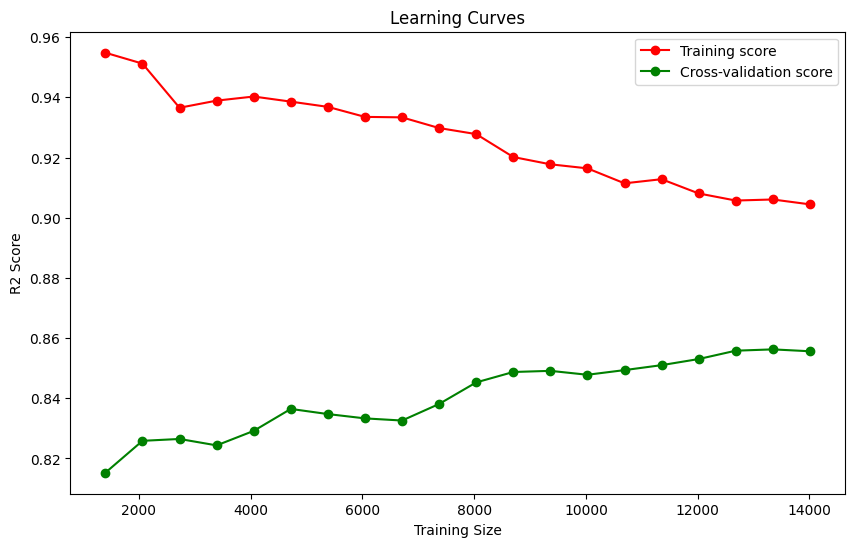

In [16]:
# Plot learning curves
plt.figure(figsize=(10, 6))
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

# Add labels and title
plt.xlabel("Training Size")
plt.ylabel("R2 Score")
plt.title("Learning Curves")
plt.legend(loc="best")
plt.show()

### 05 Exporting the pipeline as a pickle 🥒

In [18]:
import dill

# export pipe as pickle file with dill
with open('pipeline/pipeline.pkl', 'wb') as file:
    dill.settings['recurse'] = True
    dill.dump(pipeline_tuned, file)

In [19]:
# Load the pipeline using dill
with open('pipeline/pipeline.pkl', 'rb') as file:
    pipe = dill.load(file)

In [20]:
y_pred = pipe.predict(X_test)

results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Select a random sample of rows without specifying random_state
random_sample = results_df.sample(20)

# Calculate percentage difference and add a new column
random_sample['Percentage Difference'] = abs((random_sample['Predicted'] - random_sample['Actual']) / random_sample['Actual']) * 100

# Rearrange columns to place 'Actual', 'Predicted', and 'Percentage Difference' at the end
columns_order = [col for col in random_sample.columns if col not in ['Actual', 'Predicted', 'Percentage Difference']] + ['Actual', 'Predicted', 'Percentage Difference']
random_sample = random_sample[columns_order]

# Display the selected sample along with the corresponding features from X_test
results = pd.concat([random_sample, X_test.loc[random_sample.index]], axis=1).sort_values('Percentage Difference')

# Display the selected sample along with the corresponding features from X_test with styling
(pd.concat([random_sample, X_test.loc[random_sample.index]], axis=1)
 .sort_values('Percentage Difference')
 .style.applymap(lambda val: 'color: red' if val > 50 else 'color: grey', subset=['Percentage Difference']))

,Actual,Predicted,Percentage Difference,building_typology,building_gfa,primary_gfa,secondary_typology,secondary_gfa,year_built,occupancy,num_buildings
20020,349267.000000,357651.319832,2.400547,residential,28884,28884.000000,residential,28884.000000,2007,100,1
22719,248139.800000,254689.369886,2.639468,residential,58800,58800.000000,residential,58800.000000,1926,100,1
28941,371456.800000,356016.752098,4.156620,residential,94311,94311.000000,residential,94311.000000,1928,100,1
27718,1754751.800000,1845618.222119,5.178306,office,126756,126756.000000,office,126756.000000,1908,100,1
30079,232257.600000,206603.997709,11.045323,residential,44000,44000.000000,residential,44000.000000,1930,95,1
29706,304955.000000,340099.620506,11.524527,residential,88920,88920.000000,residential,88920.000000,1929,100,1
21317,319044.600000,276298.061713,13.398296,residential,44120,44120.000000,residential,44120.000000,1905,100,1
18693,2555101.200000,2205346.280936,13.688496,residential,232505,169635.000000,office,54365.000000,1983,100,1
34118,215937.500000,180913.179730,16.219656,residential,34010,34010.000000,residential,34010.000000,1926,100,1
14512,290383.700000,340099.620506,17.120768,residential,79318,79318.000000,residential,79318.000000,1952,100,1
